In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_excel('./Istanbul_StockMarket_09-11.xlsx', header=2)
data['date'] = pd.to_datetime(data.date)
feature_name = 'USD BASED ISE'
data = data[['date', feature_name]]
data.set_index('date');

In [3]:
# data = pd.read_csv('./istanbul_stock_exchange.csv')
# data['date'] = pd.to_datetime(data.date)
# feature_name = 'NIKKEI'
# data = data[['date', 'NIKKEI']]
# data.set_index('date');

In [4]:
data.tail()

,date,USD BASED ISE
531,2011-02-16,0.013400
532,2011-02-17,0.015977
533,2011-02-18,-0.001653
534,2011-02-21,-0.013706
535,2011-02-22,-0.019442


In [5]:
selected_process = data[feature_name]

In [6]:
print('Mean: ', selected_process.mean(), end='\n')
print('Variance: ', selected_process.var(), end='\n')

Mean:  0.0015522255599999997
Variance:  0.0004461357294142768


In [7]:
selected_process.cov(selected_process)

0.00044613572941427714

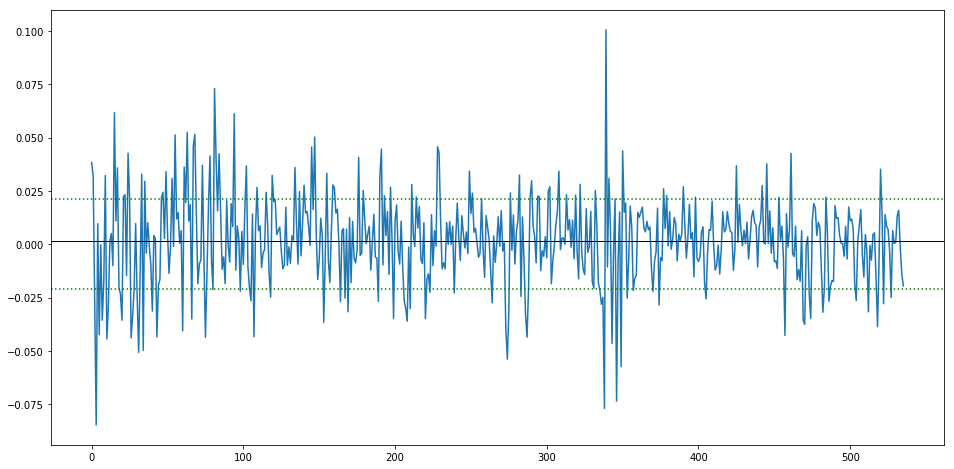

In [8]:
selected_process.plot(figsize=(16, 8));
plt.axhline(y=selected_process.mean(), color='black', linestyle='-', linewidth=1)
plt.axhline(y=selected_process.std(), color='green', linestyle=':')
plt.axhline(y=-selected_process.std(), color='green', linestyle=':');

autocovariance

In [9]:
def corrected_selective_correlation_function(values, selective_average, k):
    sum = 0.0
    for i in range(len(values)-k):
        sum += (values[i]-selective_average)*(values[i+k]-selective_average)
    return sum/(len(values)-k-1)

In [10]:
m = selected_process.size - 10
Rk = []
for i in range(m):
    Rk.append(corrected_selective_correlation_function(selected_process, selected_process.mean(), i))
rk = np.array(Rk) / selected_process.var()

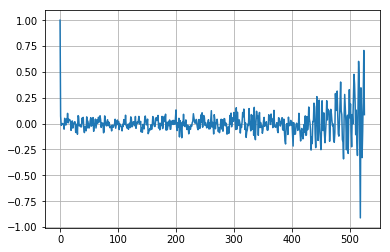

In [11]:
plt.plot(range(m), rk)
plt.grid(True)

In [12]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
plt.style.use('ggplot')

D:\Programs\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
ts = data[feature_name]

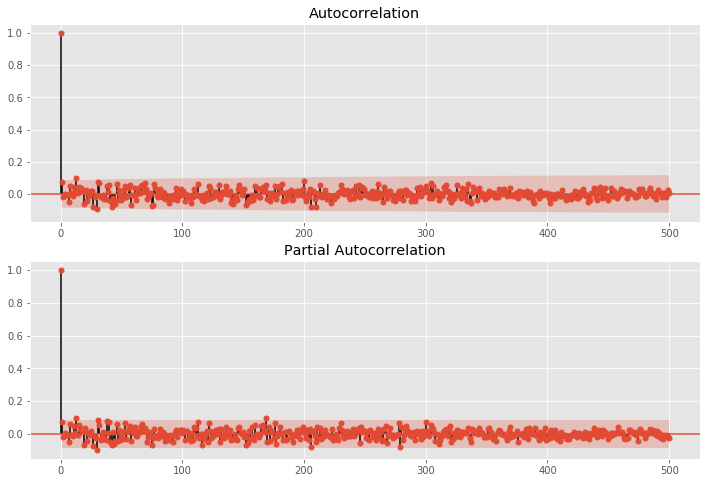

In [14]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags = 500, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags = 500, ax = ax2) # в случае частной автокорреляции остальные переменные не влияют

$\textbf{Скользящее среднее:}$

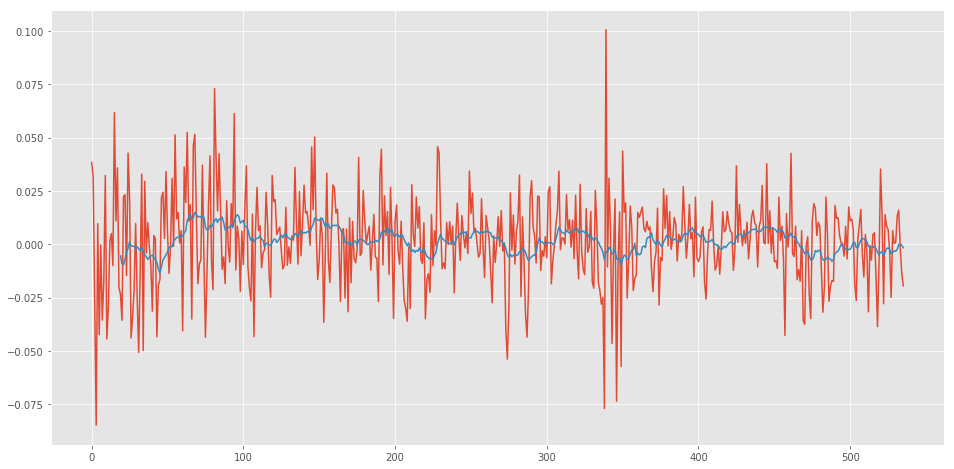

In [15]:
moving_avg = ts.rolling(window=20,center=False).mean()
ts.plot(figsize=(16, 8))
plt.plot(moving_avg)

#### Тест Дики-Фуллера

Нестационарный временной ряд соответствует случаю p-value = 1

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
def test_stationarity(timeseries):
    rolmaen = ts.rolling(window=20,center=False).mean()
    rolstd = ts.rolling(window=20,center=False).std()
    
    plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmaen, color='red', label='Rolling Mean')
    std_p = plt.plot(rolstd, color='black', label='Rolling Std')
    std_m = plt.plot(-rolstd, color='black')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
    return dfoutput

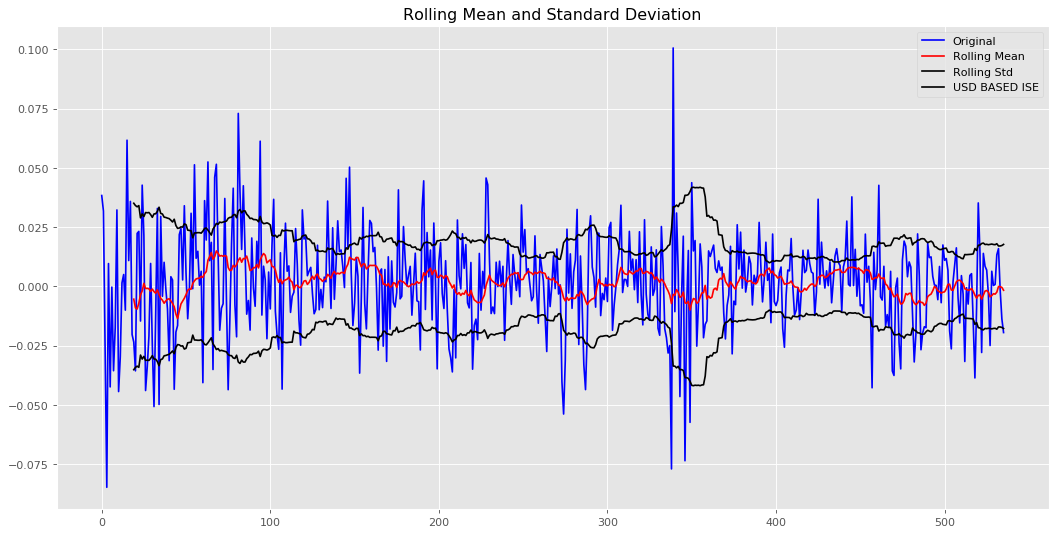

Results of Dickey-Fuller Test:


Test Statistic   -21.510292
p-value            0.000000
dtype: float64

In [18]:
test_stationarity(ts)

#### Модель авторегрессии AR

In [19]:
from statsmodels.tsa.arima_model import ARIMA

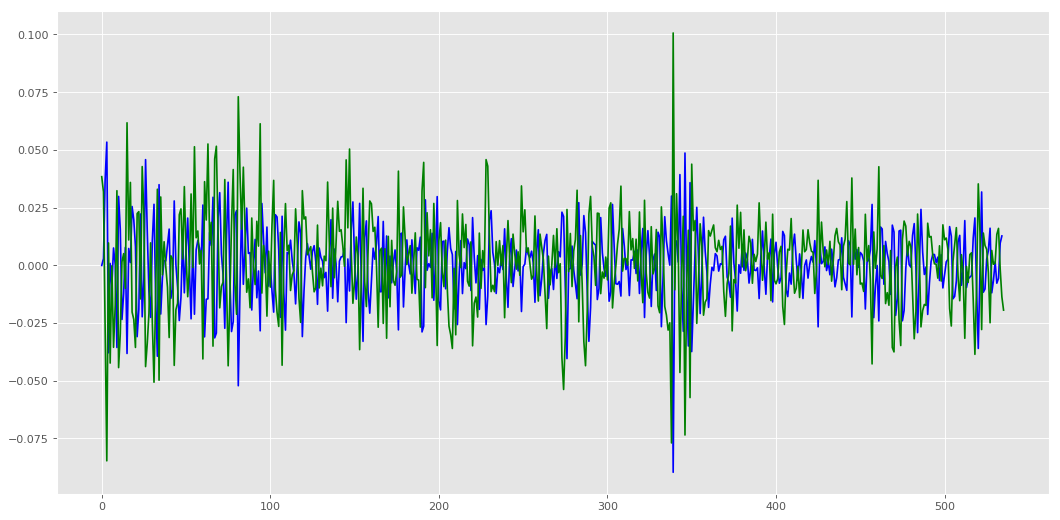

In [20]:
model = ARIMA(np.array(ts), order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(results_AR.fittedvalues, color='blue')
plt.plot(ts, color='green')

In [21]:
src_data_model = np.array(data[feature_name])
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit(full_output=True)

D:\Programs\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  535
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1303.436
Method:                       css-mle   S.D. of innovations              0.021
Date:                Wed, 23 May 2018   AIC                          -2598.871
Time:                        23:15:12   BIC                          -2581.742
Sample:                             1   HQIC                         -2592.170
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.265e-06   6.34e-06     -0.989      0.323   -1.87e-05    6.16e-06
ar.L1.D.y      0.0733      0.043      1.693      0.091      -0.012       0.158
ma.L1.D.y     -1.0000      0.006   -170.851      0.0

In [23]:
#Анализ и оценка модели
#
#Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.
#Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [24]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.029261  0.864178
1    0.068650  0.966257
2    0.069468  0.995231
3    0.071045  0.999384
4    0.071314  0.999930
5    0.082997  0.999988
6    1.758155  0.972007
7    3.449996  0.903036
8    3.455665  0.943466
9    3.558643  0.965070
10   4.477769  0.953806
11   4.509650  0.972390
12   8.295092  0.823858
13   8.481317  0.862776
14   8.719538  0.891719
15   9.143430  0.907389
16   9.700648  0.915692
17  10.047523  0.930344
18  12.545715  0.860994
19  12.629544  0.892707
20  12.799195  0.915494
21  14.475745  0.883738
22  14.589598  0.908737
23  14.600517  0.931905
24  14.907496  0.943518
25  15.490225  0.947697
26  18.540413  0.886136
27  18.557637  0.911228
28  18.663303  0.929617
29  23.612232  0.789278
30  27.449550  0.649417
31  29.712563  0.582808
32  30.000681  0.617223
33  30.111536  0.658758
34  30.143007  0.701610
35  30.505237  0.727106
36  30.889882  0.750140
37  33.047582  0.697561
38  33.094238  0.735396
39  36.042743  0.649020


Autoregressive Models - AR(p)

In [25]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [26]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

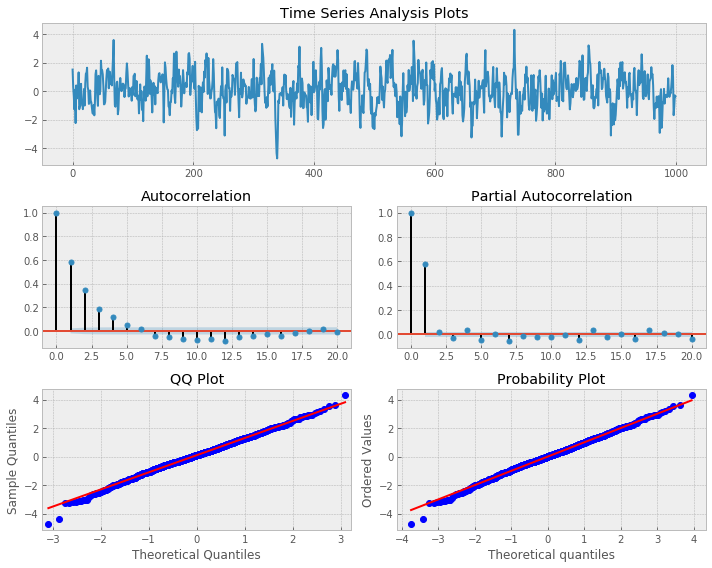

In [27]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=20)

In [28]:
mdl = smt.AR(x).fit(maxlag=30, method='mle', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 22.6 s

alpha estimate: 0.57863 | best lag order = 1

true alpha = 0.6 | true order = 1


In [29]:
print(mdl.summary())

None


In [30]:
pd.rolling_corr(ts, window=20)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20).corr(other=<Series>,pairwise=True)
  """Entry point for launching an IPython kernel.


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
506    1.0
507    1.0
508    1.0
509    1.0
510    1.0
511    1.0
512    1.0
513    1.0
514    1.0
515    1.0
516    1.0
517    1.0
518    1.0
519    1.0
520    1.0
521    1.0
522    1.0
523    1.0
524    1.0
525    1.0
526    1.0
527    1.0
528    1.0
529    1.0
530    1.0
531    1.0
532    1.0
533    1.0
534    1.0
535    1.0
Name: USD BASED ISE, Length: 536, dtype: float64

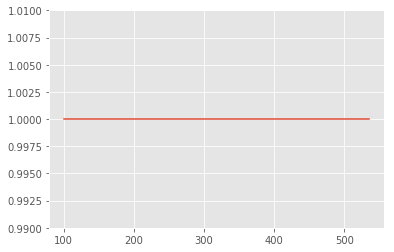

In [31]:
plt.figure()
plt.plot(ts.rolling(window=10).corr()[101:])
plt.ylim([0.99, 1.01])
plt.show()
# plt.axis((100,500,-0.1,0.1))

Spectrum dencity

In [32]:
from scipy import signal

In [153]:
spec = ifft(acf(selected_process, nlags=500))

D:\Programs\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


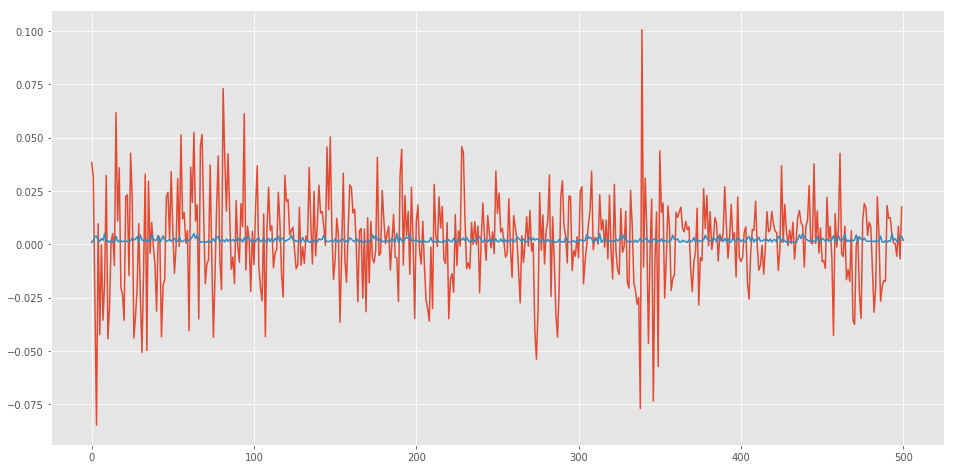

In [154]:
f, Pxx_spec = signal.periodogram(ts)
plt.figure(figsize=(16, 8))
plt.plot(ts[:500])
plt.plot(spec)

In [34]:
fs = 10e3
N = 1e5
amp = 20
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
b, a = signal.butter(2, 0.25, 'low')
x = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
y = signal.lfilter(b, a, x)
x += amp*np.sin(2*np.pi*freq*time)
y += np.random.normal(scale=0.1*np.sqrt(noise_power), size=time.shape)

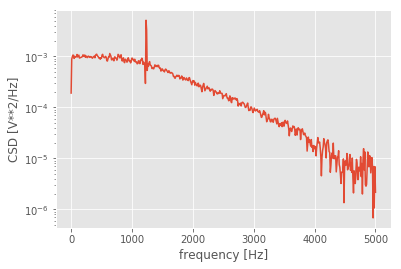

In [35]:
f, Pxy = signal.csd(x, y, fs, nperseg=1024)
plt.semilogy(f, np.abs(Pxy))
plt.xlabel('frequency [Hz]')
plt.ylabel('CSD [V**2/Hz]')
plt.show()

Err

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
  


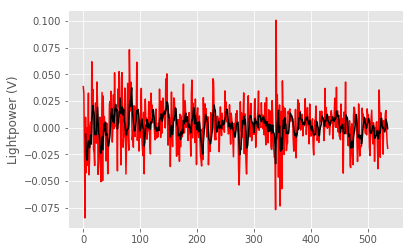

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot the Raw Data
plt.plot(ts, 'r-')
plt.ylabel('Lightpower (V)')

smooth_data = pd.rolling_mean(ts,5).plot(style='k')
plt.show()

In [37]:
from scipy.fftpack import fft, ifft, fftshift
from statsmodels.tsa.stattools import acf

In [88]:
spec = ifft(acf(selected_process, nlags=500))

D:\Programs\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


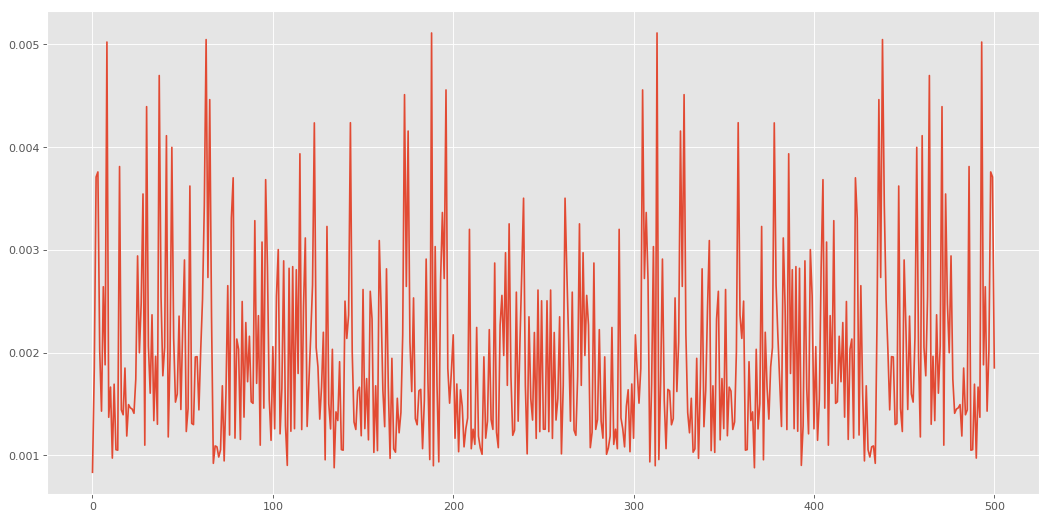

In [89]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(spec)
# plt.plot(Rk)

In [40]:
Rk

[0.00044613572941427682,
 3.2360562139108911e-05,
 -7.3822039561054316e-06,
 -4.3631420848090956e-06,
 7.9076238027980921e-07,
 -2.8267156070099517e-06,
 -2.7689768869941193e-06,
 -2.3884009460192602e-05,
 2.3088063765181381e-05,
 2.0306414218061677e-06,
 -6.2261661192590907e-06,
 1.9297405013641154e-05,
 5.6365508015090737e-06,
 4.4296507844608676e-05,
 3.1429718732608804e-06,
 1.8979779241360802e-05,
 1.7404887785247699e-05,
 1.6510156473569317e-05,
 7.4378985828476908e-06,
 -2.9001315551222077e-05,
 5.419745545430349e-06,
 1.1874977769638797e-05,
 -1.9333008715141025e-05,
 -4.8951098719733271e-06,
 3.1565363598979795e-06,
 8.2049435269083892e-06,
 7.1026750755264878e-06,
 -3.7993442116875052e-05,
 -8.5406870630356266e-06,
 -2.23786295600672e-06,
 -4.5657271341449804e-05,
 3.4439166285678579e-05,
 3.0818236923233448e-05,
 -9.3831138890606983e-06,
 -1.0089019146944407e-05,
 -3.7632547953161145e-06,
 -1.4158009425058853e-05,
 -1.3683774640139336e-05,
 2.4134528056930999e-05,
 4.3074101

In [41]:
def autocorr(x, t=1):
    return np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))

In [42]:
autocorr(np.array(selected_process))

array([[ 1.        ,  0.07267992],
       [ 0.07267992,  1.        ]])

gausian filter

In [43]:
import scipy.ndimage.filters as filters
fx = filters.gaussian_filter1d(ts,sigma=3)

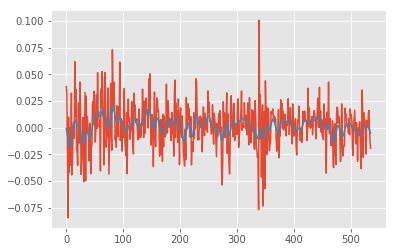

In [44]:
plt.plot(ts)
plt.plot(fx)

In [45]:
from scipy import signal

Text(0.5,0,'Sample')

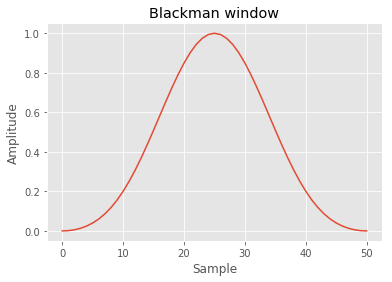

In [46]:
window = signal.blackman(51)
plt.plot(window)
plt.title("Blackman window")
plt.ylabel("Amplitude")
plt.xlabel("Sample")

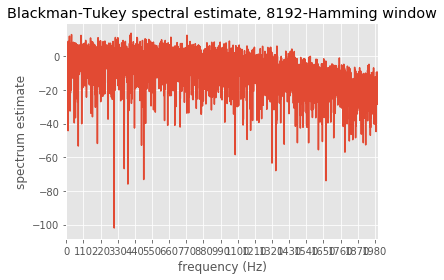

In [47]:
# Blackman-Tukey spectral esimator
from scipy.signal import correlate
from scipy.signal import hamming

# Display
db20 = lambda x: np.log10(np.abs(x)) * 20

def acorrBiased(y):
  """Obtain the biased autocorrelation and its lags
  """
  r = correlate(y, y) / len(y)
  l = np.arange(-(len(y)-1), len(y))
  return r,l

# This is a port of the code accompanying Stoica & Moses' "Spectral Analysis of
# Signals" (Pearson, 2005): http://www2.ece.ohio-state.edu/~randy/SAtext/
def blackmanTukey(y, w, Nfft, fs=1):
  """Evaluate the Blackman-Tukey spectral estimator

  Parameters
  ----------
  y : array_like
      Data
  w : array_like
      Window, of length <= y's
  Nfft : int
      Desired length of the returned power spectral density estimate. Specifies
      the FFT-length.
  fs : number, optional
      Sample rate of y, in samples per second. Used only to scale the returned
      vector of frequencies.

  Returns
  -------
  phi : array
      Power spectral density estimate. Contains ceil(Nfft/2) samples.
  f : array
      Vector of frequencies corresponding to phi.

  References
  ----------
  P. Stoica and R. Moses, *Spectral Analysis of Signals* (Pearson, 2005),
  section 2.5.1. See http://www2.ece.ohio-state.edu/~randy/SAtext/ for original
  Matlab code. See http://user.it.uu.se/~ps/SAS-new.pdf for book contents.
  """
  M = len(w)
  N = len(y)
  if M>N:
    raise ValueError('Window cannot be longer than data')
  r, lags = acorrBiased(y)
  r = r[np.logical_and(lags >= 0, lags < M)]
  rw = r * w
  phi = 2 * fft(rw, Nfft).real - rw[0];
  f = np.arange(Nfft) / Nfft;
  return (phi[f < 0.5], f[f < 0.5] * fs)


btWin = hamming(1024*8)
(pBT, fBT) = blackmanTukey(y, btWin, 16*1024, fs)

plt.close()
plt.plot(fBT, db20(pBT))
plt.xlabel('frequency (Hz)')
plt.ylabel('spectrum estimate')
plt.title('Blackman-Tukey spectral estimate, {}-Hamming window'.format(btWin.size))

plt.gca().set_xticks(np.arange(0, 2000, 110))
plt.xlim([0, 2000])
plt.tight_layout()

In [94]:
n = ts.size

In [107]:
out = []
for i in range(n):
    out.append(np.sum(np.random.normal(0, 0.001, n)*np.cos(ts+np.random.random_sample(n))))

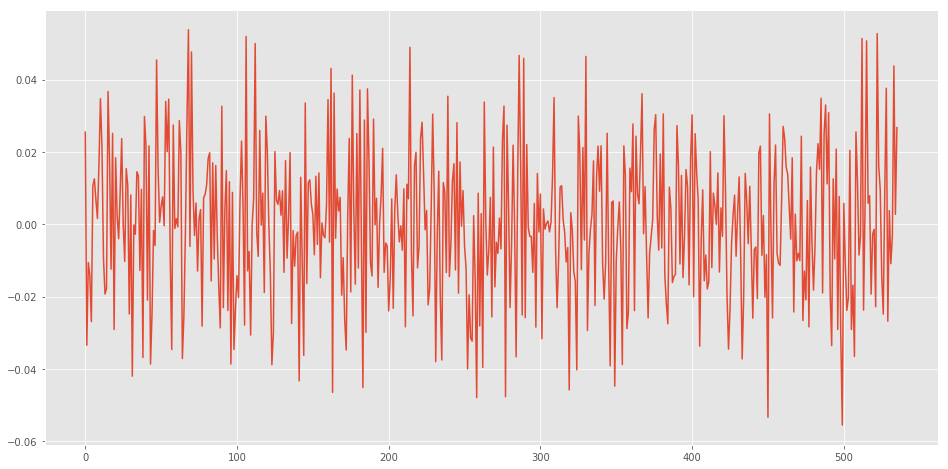

In [108]:
plt.figure(figsize=(16, 8))
plt.plot(np.array(out))

In [151]:
out = []
for i in range(n):
    out.append(np.sum(np.random.normal(0, 0.0002, n)*np.cos(moving_avg+np.random.random_sample(n))))

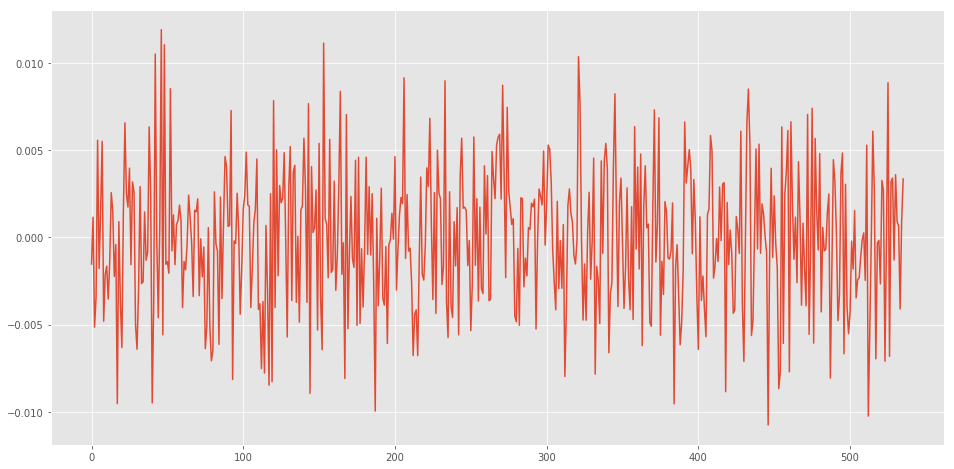

In [152]:
plt.figure(figsize=(16, 8))
plt.plot(np.array(out))

In [142]:
spec = ifft(acf(moving_avg[19:], nlags=n))

In [144]:
msum = 0.0
for i in range(19, 517):
    msum += spec[i]*(moving_avg[i+1]-moving_avg[i])